## 1. Data cleaning

In [1]:
from datetime import datetime
import pandas as pd
import regex as re
from collections import Counter
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

#import nltk vader to sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to D:\Anaconda3\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to D:\Anaconda3\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to D:\Anaconda3\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Install the relevant libraries for translation

!pip install langdetect googletrans==4.0.0-rc1 nltk

In [3]:
from langdetect import detect
from googletrans import Translator

# Initialize translation
translator = Translator()

def translate_to_english(text):
    try:
        # Detect language
        lang = detect(text)
        # If it's not English, translate it
        if lang != 'en':
            text = translator.translate(text, src=lang, dest='en').text
    except:
        pass  # If language detection or translation fails, keep the original text
    return text

In [4]:
# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
# Retain some important stop words
negations = {'not', 'no', 'nor'}
stop_words = stop_words - negations
# Add some stop words
custom_stopwords = {'yeah', 'okay', 'like', 'afternoon'}
stop_words = stop_words.union(custom_stopwords)


def clean_text(text):
    # Check if text is a string
    if isinstance(text, str):
        
        # Translate into English (if not English)
        text = translate_to_english(text)
        
        # Convert to lowercase
        text = text.lower()
        # Remove links
        text = re.sub(r'(https|http)(\S+)', '', text)
        # Remove emojis
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"  # Miscellaneous Symbols
                                   u"\U000024C2-\U0001F251"  # Enclosed Characters and Shapes
                                   "]+", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)
        # Replace username
        text = re.sub(r'@(\w+)', '', text)
        # Remove punctuation
        text = re.sub(r'[^\w\s]|[\u0080-\uffff]', '', text)
        # Replace hashtag
        text = re.sub(r'#', '', text)
        # Replace retweets
        text = re.sub(r'rt', '', text)
        # Tokenize the text
        tokens = word_tokenize(text)
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        # Perform stemming and lemmatization
        # stemmed_tokens = [stemmer.stem(token) for token in tokens]
        # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
        # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        text = ' '.join(tokens)
        # Join tokens back into text
        # text = ' '.join(lemmatized_tokens)
        # Trim whitespace
        text = text.strip()
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)        
        text = re.sub(r'  ', '', text)
    return text

In [5]:
text = "你好"
print(translate_to_english(text),'||',clean_text(text))
text1 = "selamat petang" #こんにちは
print(translate_to_english(text1),'||',clean_text(text1))
text2 = "Check out this link: http://example.com #awesome RT @user1'"
print(translate_to_english(text2),'||',clean_text(text2))
text3 = "Pengalaman penerbangan ini tidak bagus"
print(translate_to_english(text3),'||',clean_text(text3))

Hello || hello
Good afternoon || good
Check out this link: http://example.com #awesome RT @user1' || check link awesome
This flight experience is not good || flight experience not good


## 2. Read data and apply cleaning

In [6]:
import os
import pandas as pd

In [7]:
!pip install tqdm

In [8]:
def read_excel_and_clean(file_path, column_name):
    import os
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()

    file_ext = os.path.splitext(file_path)[1].lower()

    if file_ext == '.csv':
        try:
            df = pd.read_csv(file_path, encoding='utf-8')  # 尝试 utf-8
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='gb18030')  # 如果失败，用 gb18030

        df = df.dropna(axis=1, how='all')  # Drop completely empty columns
        df.columns = df.columns.str.strip()  # 去掉列名的空格
        file_path = file_path.rsplit('.', 1)[0] + '.xlsx'
        df.to_excel(file_path, index=False)
    else:
        df = pd.read_excel(file_path)
        df.columns = df.columns.str.strip()

    df['original text'] = df[column_name]

    print("Translating text to English...")
    df['translated text'] = df['original text'].progress_apply(translate_to_english)

    print("Cleaning translated text...")
    df['cleansed data'] = df['translated text'].progress_apply(clean_text)

    df = df[df['cleansed data'].str.strip().astype(bool)]

    return df



In [9]:
import pandas as pd

file_path = "./cleaned_taobao_reviews.csv"
df = pd.read_csv(file_path)
print(df.columns)


Index(['评论ID', '用户名', '评论内容', '清洗后评论', '处理后文本', '评分', '点赞数', '评论时间',
       'cleaned_review'],
      dtype='object')


In [10]:
# !pip install --upgrade openpyxl
# Example usage
file_path = "./cleaned_taobao_reviews.csv"
column_name = "处理后文本"
df_cleaned = read_excel_and_clean(file_path, column_name)
print(df_cleaned[column_name].head(5))
print("Data after translating:")
print(df_cleaned['translated text'].head(5))
print("Data after cleaning:")
print(df_cleaned['cleansed data'].head(5))
# 

Translating text to English...


100%|██████████| 5000/5000 [09:47<00:00,  8.51it/s] 


Cleaning translated text...


100%|██████████| 5000/5000 [06:59<00:00, 11.92it/s] 

0    ive using app month options good however main ...
1    language barrier unfortunately language option...
2    keeps sign repeatedly claims security risks ac...
3    pretty satisfying cheap thing though ask sign ...
4    bought two hundred products since last year fr...
Name: 处理后文本, dtype: object
Data after translating:
0    ive using app month options good however main ...
1    language barrier unfortunately language option...
2    keeps sign repeatedly claims security risks ac...
3    pretty satisfying cheap thing though ask sign ...
4    bought two hundred products since last year fr...
Name: translated text, dtype: object
Data after cleaning:
0    ive using app month options good however main ...
1    language barrier unfounately language option a...
2    keeps sign repeatedly claims security risks ac...
3    pretty satisfying cheap thing though ask sign ...
4    bought two hundred products since last year fr...
Name: cleansed data, dtype: object


## 3. Sentiment analysis

In [11]:
#import nltk vader to sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [12]:
def analyze_sentiment(df, column_name):
    # Create sentiment analyzer object
    analyzer = SentimentIntensityAnalyzer()
    
    # Sentiment analysis function
    def analyze_single_text(text):
        text = str(text)  # Ensure input is string
        sentiment_score = analyzer.polarity_scores(text)
        compound_score = sentiment_score['compound']
        if compound_score > 0.05:
            return 'Positive'
        elif compound_score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    # Perform sentiment analysis on specific column and add results to a new column
    df['Sentiment'] = df[column_name].apply(analyze_single_text)
    df['Compound'] = df[column_name].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])  # optional


    return df


In [13]:
df_cleaned_sentiment = analyze_sentiment(df_cleaned, 'cleansed data')
print(df_cleaned_sentiment['Sentiment'].head(5))

0    Positive
1    Positive
2    Positive
3    Positive
4    Positive
Name: Sentiment, dtype: object


In [14]:
df.head(5)

,评论ID,用户名,评论内容,清洗后评论,处理后文本,评分,点赞数,评论时间,cleaned_review
0,fa046802-4a1c-45d3-84a6-68c02e875ed5,Maria Nelly Arevalo Toala,"I've been using this app for about a month, an...",ive been using this app for about a month and ...,ive using app month options good however main ...,2,37,2025-05-15 07:51:21,ive using app month options good however main ...
1,588015dc-9dfe-408f-8bdf-f6a3c274780d,Rayna Maschan,"Language Barrier and unfortunately, the only l...",language barrier and unfortunately the only la...,language barrier unfortunately language option...,3,217,2025-04-14 08:45:44,language barrier unfortunately language option...
2,342b6a5f-1f2d-4ecb-af6a-35b3da4116e7,Celina Lee,Keeps having you sign in repeatedly then claim...,keeps having you sign in repeatedly then claim...,keeps sign repeatedly claims security risks ac...,1,268,2025-04-12 02:08:13,keeps sign repeatedly claims security risks ac...
3,bd012696-c2d0-436c-a163-970b89e8ae21,Greg,It's pretty satisfying and cheap. Only thing i...,its pretty satisfying and cheap only thing is ...,pretty satisfying cheap thing though ask sign ...,2,149,2025-03-11 05:57:00,pretty satisfying cheap thing though ask sign ...
4,48835ad9-b550-4a5d-8775-7268349d4e01,Linda Wong,I bought more than two hundred products since ...,i bought more than two hundred products since ...,bought two hundred products since last year fr...,5,1000,2025-04-21 16:23:18,bought two hundred products since last year fr...


## 4. Save file

In [15]:
def write_to_excel(df, output_file):
    # Remove fully empty columns before saving
    df = df.dropna(axis=1, how='all')
    # Write the DataFrame with sentiment analysis results to Excel
    df.to_excel(output_file, index=False)

In [16]:
output_file = 'output_taobao_file.xlsx'
write_to_excel(df_cleaned_sentiment, output_file)

In [17]:
# Obtain the location of the file
import os
os.path.abspath('.')

'D:\\jupyter_project\\individual_assignment\\taobao'

## 5. A part of the data statistics and visualization

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline


In [51]:

def plot_selected_sentiment_trend_yearly(df, selected_sentiment='Positive', sentiment_column='Sentiment', save_path=None):
    df = df.copy()

    if '评论时间' in df.columns:
       df['ParsedDate'] = pd.to_datetime(df['评论时间'], errors='coerce')  # ✅正确的
    elif 'Review Date' in df.columns:
        df['ParsedDate'] = pd.to_datetime(df['Reviwe Date'], unit='s', errors='coerce')
    else:
        raise ValueError("Expected 'Review Date' or 'at' column for date information.")

    df = df.dropna(subset=['ParsedDate', sentiment_column])
    df['Year'] = df['ParsedDate'].dt.year

    df_filtered = df[df[sentiment_column] == selected_sentiment]
    yearly_counts = df_filtered.groupby('Year').size().sort_index()

    x = np.arange(len(yearly_counts))
    y = yearly_counts.values
    years = yearly_counts.index

    plt.figure(figsize=(16, 10))

    if len(x) >= 4:
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=selected_sentiment, color='teal')
    else:
        plt.plot(x, y, label=selected_sentiment, color='teal')

    plt.xticks(ticks=np.arange(len(years)), labels=[str(year) for year in years], rotation=45)
    plt.xlabel("Year", fontsize=22)
    plt.ylabel("Number of Reviews", fontsize=22)
    plt.title(f"Yearly Trend of {selected_sentiment} Sentiment", fontsize=26)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=22)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)

    plt.show()


In [52]:
print(df_cleaned['Sentiment'].value_counts())

Sentiment
Positive    1795
Neutral     1754
Negative    1449
Name: count, dtype: int64


In [53]:
print(df_cleaned.columns)

Index(['评论ID', '用户名', '评论内容', '清洗后评论', '处理后文本', '评分', '点赞数', '评论时间',
       'cleaned_review', 'original text', 'translated text', 'cleansed data',
       'Sentiment', 'Compound'],
      dtype='object')


In [54]:
print(df_cleaned['处理后文本'].head())

0    ive using app month options good however main ...
1    language barrier unfortunately language option...
2    keeps sign repeatedly claims security risks ac...
3    pretty satisfying cheap thing though ask sign ...
4    bought two hundred products since last year fr...
Name: 处理后文本, dtype: object


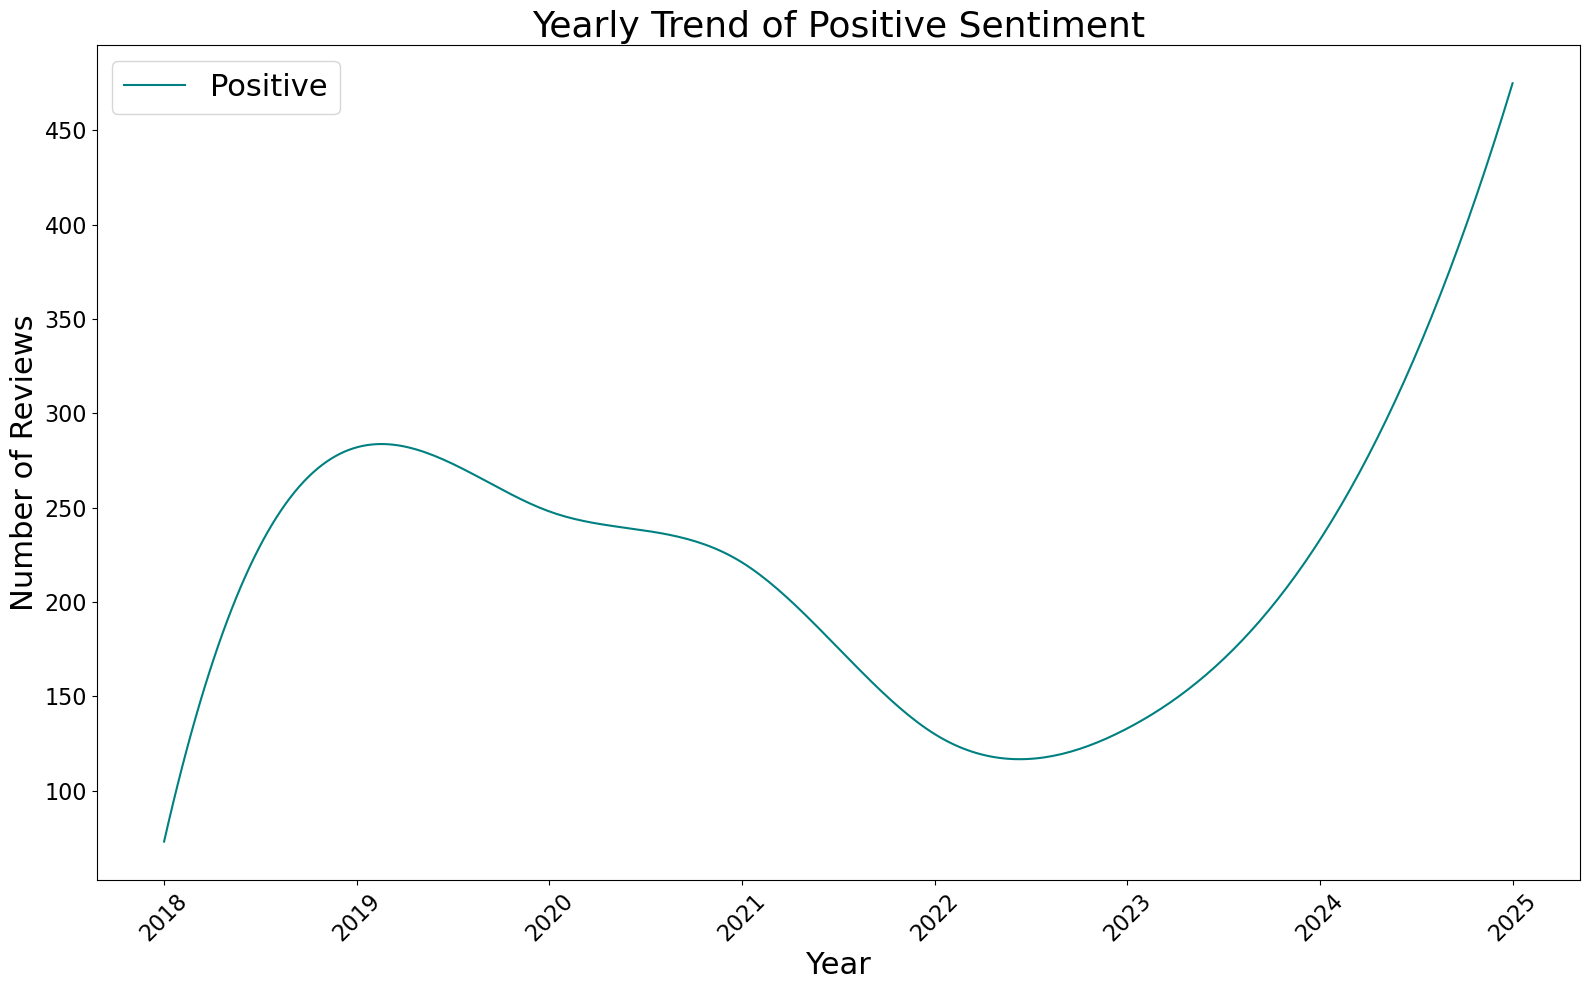

In [55]:
plot_selected_sentiment_trend_yearly(df_cleaned, selected_sentiment='Positive')


In [60]:
def plot_selected_sentiment_trend_monthly(df, selected_sentiment='Positive', sentiment_column='Sentiment', save_path=None):
    df = df.copy()

    if '评论时间' in df.columns:
        df['ParsedDate'] = pd.to_datetime(df['评论时间'], errors='coerce')
    elif 'at' in df.columns:
        df['ParsedDate'] = pd.to_datetime(df['at'], errors='coerce')
    else:
        raise ValueError("No supported time column found. Expected 'Review Date' or 'at'.")

    df = df.dropna(subset=['ParsedDate', sentiment_column])
    df['Month'] = df['ParsedDate'].dt.to_period('M').dt.to_timestamp()

    df_filtered = df[df[sentiment_column] == selected_sentiment]
    monthly_counts = df_filtered.groupby('Month').size().sort_index()

    x = np.arange(len(monthly_counts))
    y = monthly_counts.values
    months = monthly_counts.index

    plt.figure(figsize=(16, 10))

    if len(x) >= 4:
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=selected_sentiment, color='steelblue')
    else:
        plt.plot(x, y, label=selected_sentiment, color='steelblue')

    plt.xticks(
        ticks=np.arange(len(months)),
        labels=[m.strftime("%Y-%m") for m in months],
        rotation=45
    )
    plt.xlabel("Month", fontsize=22)
    plt.ylabel("Number of Reviews", fontsize=22)
    plt.title(f"Monthly Trend of {selected_sentiment} Sentiment", fontsize=26)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(fontsize=22)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.savefig(f"Monthly Trend of {selected_sentiment} Sentiment.jpg", dpi=300)

    plt.show()


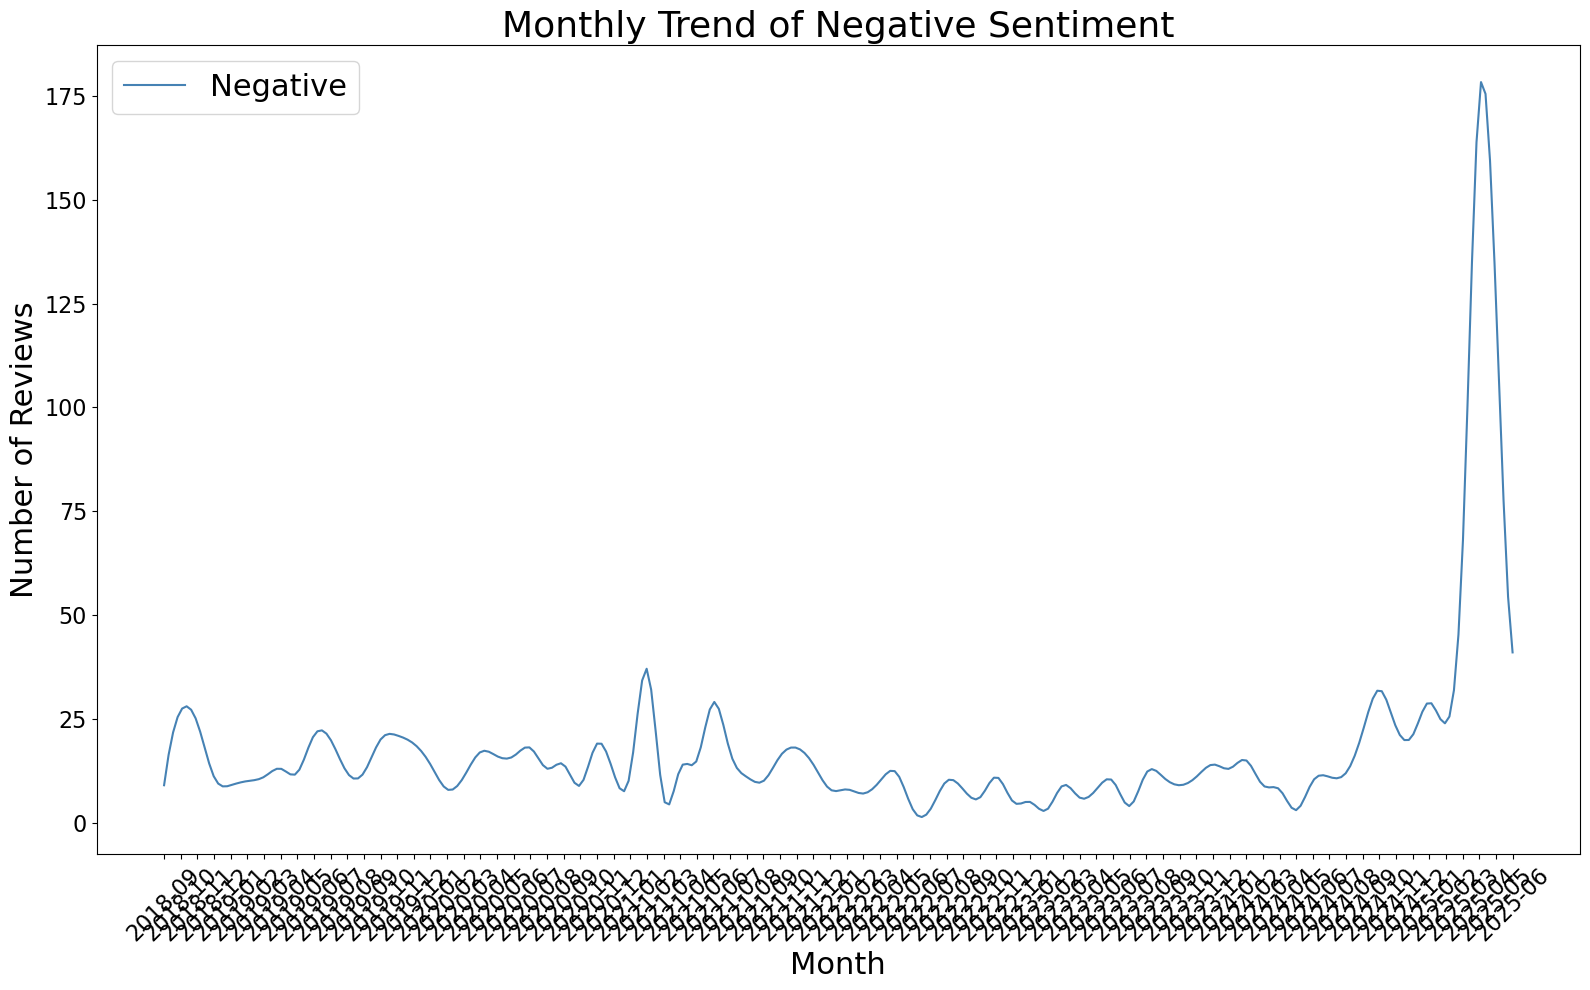

In [61]:
plot_selected_sentiment_trend_monthly(df_cleaned, selected_sentiment='Negative')


In [66]:
def plot_selected_sentiment_trend(df, selected_sentiment='Positive', sentiment_column='Sentiment', save_path=None):
    """
    Plot smoothed trend over time for a selected sentiment.

    Parameters:
        df: DataFrame containing sentiment and a time column
        selected_sentiment: 'Positive', 'Negative', or 'Neutral'
        sentiment_column: name of the sentiment column
        save_path: optional path to save the figure at 300 dpi
    """
    df = df.copy()

    if '评论时间' in df.columns:
        df['ParsedDate'] = pd.to_datetime(df['评论时间'], errors='coerce')
    elif 'at' in df.columns:
        df['ParsedDate'] = pd.to_datetime(df['at'], errors='coerce')
    else:
        raise ValueError("No supported time column found. Expected 'Review Date' or 'at'.")

    df = df.dropna(subset=['ParsedDate', sentiment_column])
    df['Date'] = df['ParsedDate'].dt.date

    df_filtered = df[df[sentiment_column] == selected_sentiment]
    sentiment_counts = df_filtered.groupby('Date').size().sort_index()

    x = np.arange(len(sentiment_counts))
    y = sentiment_counts.values
    dates = sentiment_counts.index

    plt.figure(figsize=(16, 10))

    if len(x) >= 4:
        x_smooth = np.linspace(x.min(), x.max(), 300)
        spline = make_interp_spline(x, y, k=3)
        y_smooth = spline(x_smooth)
        plt.plot(x_smooth, y_smooth, label=selected_sentiment, color='steelblue')
    else:
        plt.plot(x, y, label=selected_sentiment, color='steelblue')

    plt.xticks(
        ticks=np.linspace(0, len(dates) - 1, num=min(len(dates), 12), dtype=int),
        labels=[str(dates[i]) for i in np.linspace(0, len(dates) - 1, num=min(len(dates), 12), dtype=int)],
        rotation=45
    )

    plt.xlabel("Date", fontsize=22)
    plt.ylabel("Number of Reviews", fontsize=22)
    plt.title(f"Daily Trend of {selected_sentiment} Sentiment Over Time", fontsize=26)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(fontsize=18)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    else:
        plt.savefig(f"Daily Trend of {selected_sentiment} Sentiment.jpg", dpi=300)

    plt.show()


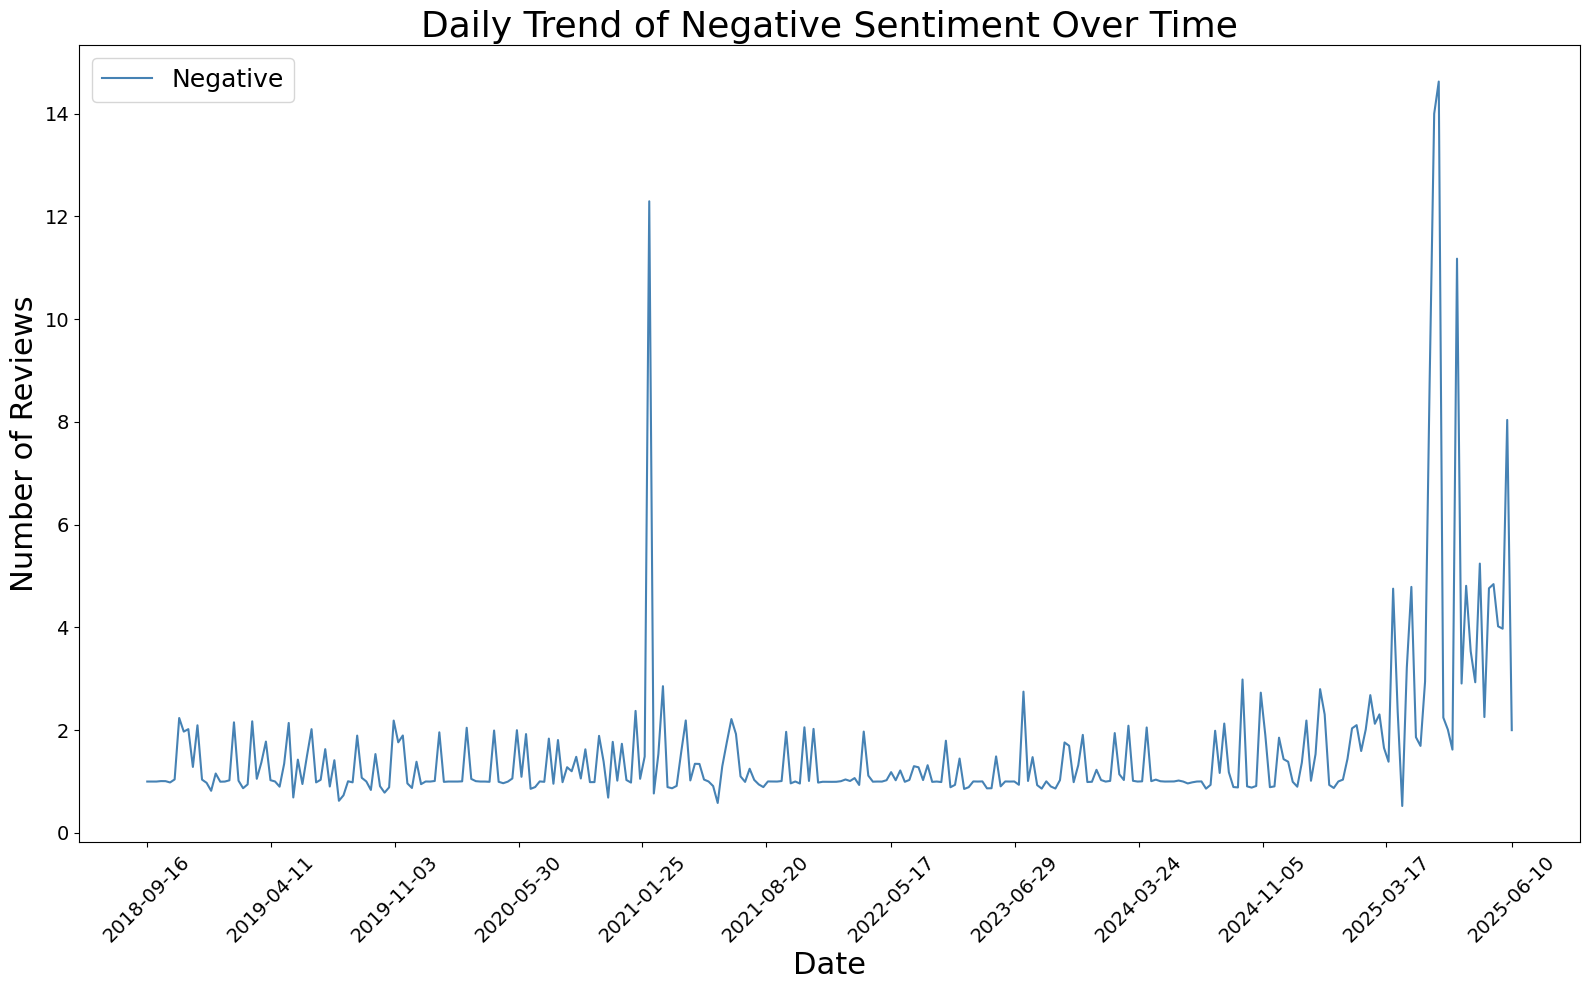

In [67]:
plot_selected_sentiment_trend(df_cleaned, selected_sentiment='Negative')


In [68]:
from collections import Counter
from nltk.corpus import stopwords

# def calculate_word_freq_by_sentiment(df, text_column, sentiment_column='Sentiment'):
#     # Dictionary to hold word frequency per sentiment
#     sentiment_word_freq = {}

#     # Sentiment-specific word frequencies
#     for sentiment in ['Positive', 'Negative', 'Neutral']:
#         filtered_df = df[df[sentiment_column] == sentiment]
#         cleaned_text = ' '.join(filtered_df[text_column].dropna().values)
#         words = cleaned_text.split()
#         word_freq = Counter(words)
#         sentiment_word_freq[sentiment] = word_freq

#     # Overall word frequency (all sentiments)
#     all_text = ' '.join(df[text_column].dropna().values)
#     all_words = all_text.split()
#     sentiment_word_freq['All'] = Counter(all_words)

#     return sentiment_word_freq


def calculate_word_freq_by_sentiment(df, text_column, sentiment_column='Sentiment'):
    # Load English stopwords
    stop_words = set(stopwords.words('english'))
    # Retain some important stop words
    # negations = {'not', 'no', 'nor'}
    # stop_words = stop_words - negations
    # # Add some stop words
    # custom_stopwords = {'yeah', 'okay', 'like', 'afternoon'}
    # stop_words = stop_words.union(custom_stopwords)

    # Dictionary to hold word frequency per sentiment
    sentiment_word_freq = {}

    # Sentiment-specific word frequencies
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        filtered_df = df[df[sentiment_column] == sentiment]
        cleaned_text = ' '.join(filtered_df[text_column].dropna().values)
        words = cleaned_text.split()
        filtered_words = [word for word in words if word.lower() not in stop_words]
        word_freq = Counter(filtered_words)
        sentiment_word_freq[sentiment] = word_freq

    # Overall word frequency (all sentiments)
    all_text = ' '.join(df[text_column].dropna().values)
    all_words = all_text.split()
    all_filtered_words = [word for word in all_words if word.lower() not in stop_words]
    sentiment_word_freq['All'] = Counter(all_filtered_words)

    return sentiment_word_freq


In [69]:
# # Calculate word frequencies after removing stopwords
# word_freq = calculate_word_freq(df_cleaned_sentiment, 'cleansed data')

# # Print the top 20 words and their frequencies
# print("Top 20 words and their frequencies after cleaning and removing stopwords:")
# for word, freq in word_freq.most_common(20):
#     print(word, freq)
word_frequencies = calculate_word_freq_by_sentiment(df_cleaned_sentiment, 'cleansed data')
all_word_freq = word_frequencies['All'].most_common()
pos_word_freq = word_frequencies['Positive'].most_common()
neg_word_freq = word_frequencies['Negative'].most_common()
neu_word_freq = word_frequencies['Neutral'].most_common()

print('All: ', word_frequencies['All'].most_common(10))        # The first 10 words of all emotions
print('Positive: ',word_frequencies['Positive'].most_common(10))   # The first 10 words of positive


All:  [('app', 2010), ('english', 1570), ('cant', 890), ('language', 812), ('chinese', 634), ('account', 526), ('please', 493), ('use', 481), ('version', 465), ('dont', 456)]
Positive:  [('app', 836), ('english', 609), ('please', 396), ('good', 304), ('language', 302), ('chinese', 263), ('cant', 261), ('use', 216), ('version', 185), ('dont', 173)]


In [70]:
import matplotlib.pyplot as plt
# !pip install wordcloud
from wordcloud import WordCloud

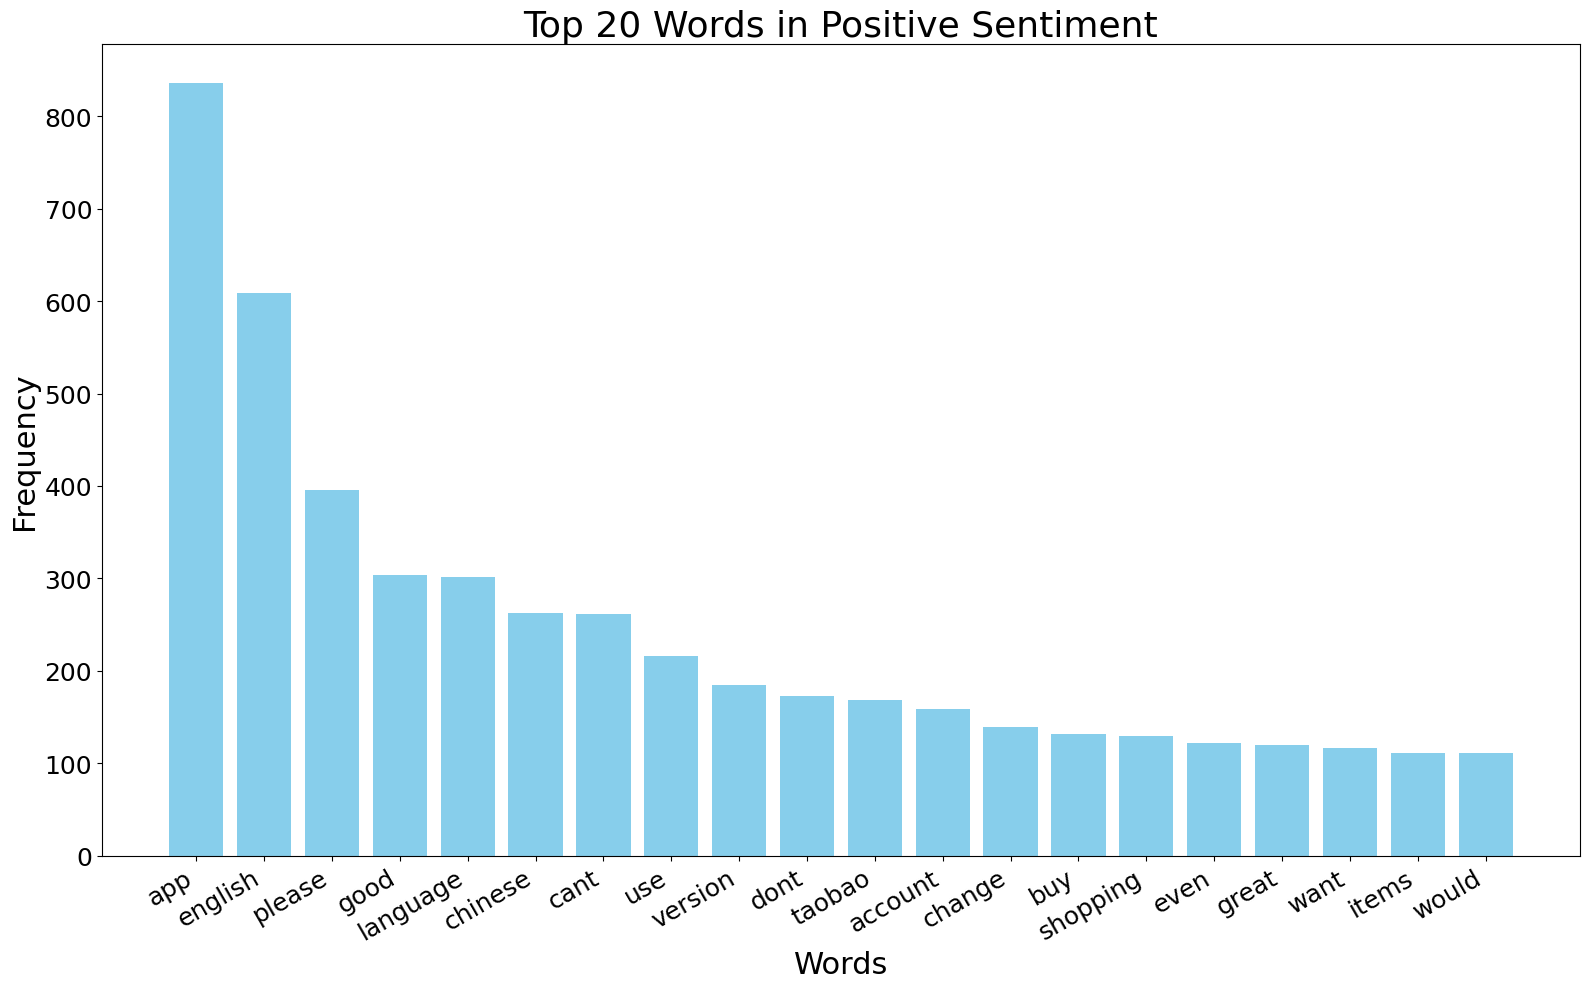

In [71]:
# Plot a bar chart
def plot_word_freq(word_freq_dict, sentiment='All', top_n=20):
    if sentiment not in word_freq_dict:
        print(f"Sentiment '{sentiment}' not found. Choose from {list(word_freq_dict.keys())}")
        return
    
    freq_data = word_freq_dict[sentiment].most_common(top_n)
    
    if not freq_data:
        print(f"No words to display for sentiment: {sentiment}")
        return

    words, freqs = zip(*freq_data)

    plt.figure(figsize=(16, 10))
    plt.bar(words, freqs, color='skyblue')
    plt.title(f"Top {top_n} Words in {sentiment} Sentiment", fontsize=26)
    plt.xlabel("Words", fontsize=22)
    plt.ylabel("Frequency", fontsize=22)
    plt.xticks(rotation=30, ha='right', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"Top {top_n} Words in {sentiment} Sentiment.jpg", dpi=300)
    plt.show()

plot_word_freq(word_frequencies, sentiment='Positive', top_n=20)

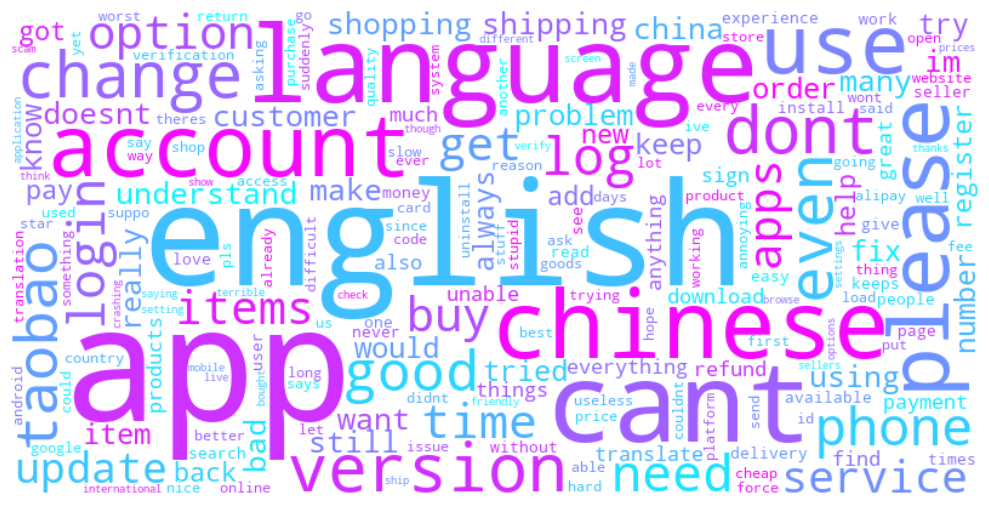

In [72]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(word_freq_dict, sentiment='All'):

    if sentiment not in word_freq_dict:
        print(f"Sentiment '{sentiment}' not found. Choose from {list(word_freq_dict.keys())}")
        return

    freq = word_freq_dict[sentiment]
    if not freq:
        print(f"No words to display for sentiment: {sentiment}")
        return

    wc = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='cool'  # change color: 'viridis', 'plasma', 'inferno', 'magma', 'cool', 'spring', 'summer', 'autumn', 'winter', 'cividis'
     ).generate_from_frequencies(freq)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    # plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.tight_layout()
    plt.savefig(f"Word Cloud for {sentiment} Sentiment.jpg", dpi=300)
    plt.show()


plot_wordcloud(word_frequencies, sentiment='All')


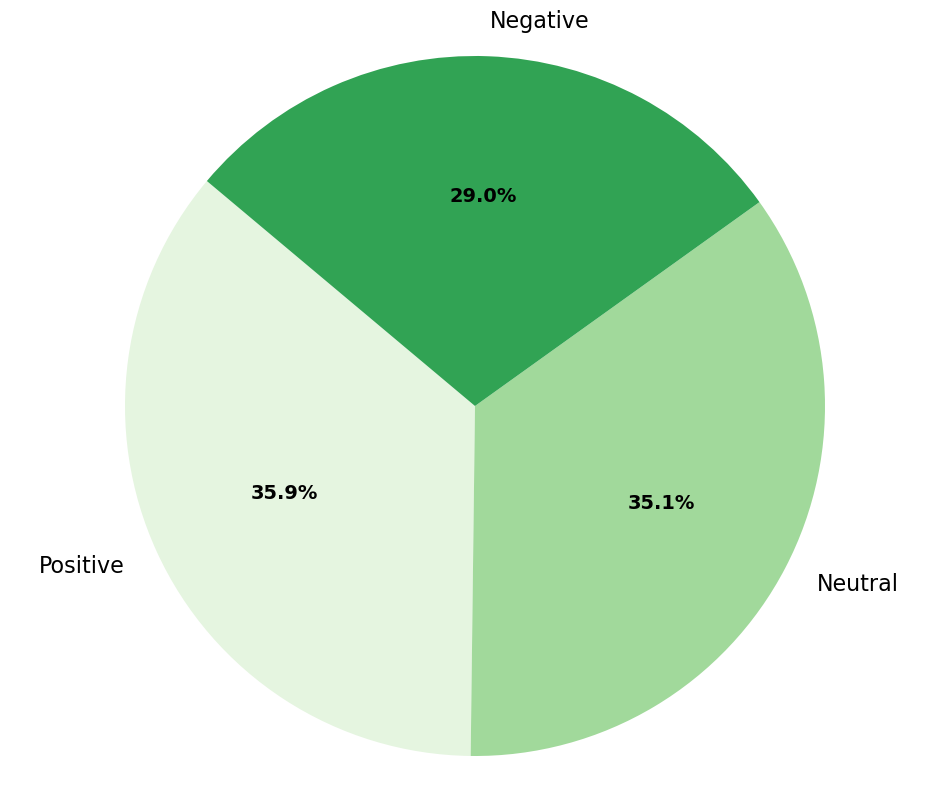

In [73]:
import matplotlib.pyplot as plt

def generate_pie_chart(df):
    sentiment_counts = df['Sentiment'].value_counts()
    colors = ['#e5f5e0','#a1d99b','#31a354','#238b45'] # You can adjust the color according to the number of categories
    plt.figure(figsize=(12, 10))
    wedges, texts, autotexts = plt.pie(
        sentiment_counts,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        textprops={'fontsize': 16}  #Set the font size of the labels and percentages
    )
    plt.setp(autotexts, size=14, weight="bold")  # The percentage text is bolded
    plt.axis('equal')  # Keep the pie chart round
    # plt.title('Sentiment Distribution', fontsize=20)
    plt.savefig('Pie_chart_Airlines.jpg', dpi=300)
    plt.show()

generate_pie_chart(df_cleaned_sentiment)
